In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F

## Data Preparation & Preprocessing

In [88]:
# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)  # Set seed for numpy
    random.seed(seed)  # Set seed for random
    
    if torch.cuda.is_available():
        torch.manual_seed(seed)  # Set seed for PyTorch CPU
    
    torch.cuda.manual_seed(seed)  # Set seed for PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
    torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for GPUs

set_seed(42)

In [89]:
# Load the data
def load_data(file):
    # Load the data
    data = pd.read_csv('data/' + file + '.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # round to 2 decimal places
    data = data.round(2) 

    return data

data = load_data('SP500')

In [90]:
# Preprocess the data (using min-max scaler)
def normalize(features):
    min_val = np.min(features)
    max_val = np.max(features)
    return (features - min_val) / (max_val - min_val)
    
features = np.array(data[['Close']])
scaled_data = normalize(features)

In [91]:
# Load hyperparameters
with open('configs/configs.json', 'r') as file:
    hyperparams = json.load(file)

In [92]:
# Create sequences
def create_sequences(data, input_size, num_steps, val_split=0.1, test_split=0.1):
    data = [np.array(data[i * input_size: (i + 1) * input_size]) 
       for i in range(len(data) // input_size)]

    # Split into groups of `num_steps`
    X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
    y = np.array([data[i + num_steps] for i in range(len(data) - num_steps)])

    # Reshape X to have shape (N, num_steps, input_size)
    X = X.reshape(-1, num_steps, input_size)
    y = y.reshape(-1, input_size)  # Reshape y to match the output shape

    # Split into train, validation, and test sets
    total_len = len(X)
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))
    
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [93]:
num_steps = hyperparams['num_steps']  # Extract number of steps
input_size = hyperparams['input_size']  # Extract input size
val_split = hyperparams['val_split']  # Extract validation split
test_split = hyperparams['test_split']  # Extract test split
X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(scaled_data, input_size, num_steps, val_split, test_split)

In [94]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

assert(not torch.isnan(X_train_tensor).any())
assert(not torch.isnan(y_train_tensor).any())
assert(not torch.isnan(X_val_tensor).any())
assert(not torch.isnan(y_val_tensor).any())
assert(not torch.isnan(X_test_tensor).any())
assert(not torch.isnan(y_test_tensor).any())

In [95]:
# Create DataLoader instances
batch_size = hyperparams['batch_size']
num_workers = hyperparams['num_workers']  # Extract number of workers from hyperparameters
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

## Model Definition: LSTM Cell

In [96]:
# Extract hyperparameters
def extract_hyperparams(hyperparams, model):
    num_units = hyperparams[model][model + '_units']
    num_layers = hyperparams[model][model + '_layers']
    dropout_rate = hyperparams[model]['dropout_rate']
    dense_units = hyperparams[model]['dense_units']
    max_epochs = hyperparams[model]['max_epochs']
    use_early_stop = hyperparams[model]['use_early_stop']
    early_stop_patience = hyperparams[model]['early_stop_patience']
    train_needed = hyperparams[model]['pretrain'] # Whether to train the model

    return num_units, num_layers, dropout_rate, dense_units, max_epochs, use_early_stop, early_stop_patience, train_needed

num_units, num_layers, dropout_rate, dense_units, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'lstm')

In [97]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_c = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_o = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)
        
        # Check for NaN values
        for name, param in self.named_parameters():
            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.ln_i(torch.mm(x, self.W_i) + torch.mm(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.mm(x, self.W_f) + torch.mm(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.mm(x, self.W_c) + torch.mm(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.mm(x, self.W_o) + torch.mm(h, self.U_o) + self.b_o))

        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
    
        return h_t, c_t

In [98]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(hidden_dim, dense_units)  # Dense layer with `hidden_dim` to `dense_units`
        self.fc = nn.Linear(dense_units, output_dim)    # Final linear layer with `dense_units` to `output_dim`

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        if self.cell_type == 'lstm':
            c = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in self.layers:
                if self.cell_type == 'lstm':
                    h, c = layer(x_t, h, c)
                elif self.cell_type == 'gru':
                    h = layer(x_t, h)
                x_t = self.dropout(h)

        out = self.dense(h)  # Pass through dense layer
        out = self.fc(out)  # Pass through final linear layer
        return out

In [99]:
# Instantiate the model
input_dim = X_train_tensor.shape[-1]
output_dim = y_train_tensor.shape[-1]

model = CustomRNNModel(input_dim=input_dim, hidden_dim=num_units, output_dim=output_dim, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type='lstm')
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
learning_rate = hyperparams['lstm']['learning_rate']
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
def train_model(model, cell_type, train_loader, val_loader, epochs, learning_rate, use_early_stop, early_stop_patience, train_needed):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss_sum = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            if torch.isnan(inputs).any() or torch.isnan(targets).any():
                print("NaN detected in inputs or targets during training")
                continue

            try:
                outputs = model(inputs)
            except RuntimeError as e:
                print(f"RuntimeError during training: {e}")
                continue
            
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, targets)
            
            if torch.isnan(loss):
                print("NaN loss encountered during training")
                continue

            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item() * inputs.size(0)
        
        avg_train_loss = train_loss_sum / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                if torch.isnan(inputs).any() or torch.isnan(targets).any():
                    print("NaN detected in inputs or targets during validation")
                    continue

                try:
                    outputs = model(inputs)
                except RuntimeError as e:
                    print(f"RuntimeError during validation: {e}")
                    continue
                
                outputs = outputs.squeeze(-1)
                loss = criterion(outputs, targets)
                
                if torch.isnan(loss):
                    print("NaN validation loss encountered")
                    continue

                val_loss_sum += loss.item() * inputs.size(0)

        avg_val_loss = val_loss_sum / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if use_early_stop:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print("Early stopping triggered")
                    break

    if use_early_stop:
        model.load_state_dict(torch.load(f'models/SP500_{cell_type}_model.pth'))

    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

Epoch 1/50, Train Loss: 0.0481, Validation Loss: 0.2062
Epoch 2/50, Train Loss: 0.0249, Validation Loss: 0.1010
Epoch 3/50, Train Loss: 0.0183, Validation Loss: 0.0502
Epoch 4/50, Train Loss: 0.0122, Validation Loss: 0.0204
Epoch 5/50, Train Loss: 0.0088, Validation Loss: 0.0162
Epoch 6/50, Train Loss: 0.0050, Validation Loss: 0.0147
Epoch 7/50, Train Loss: 0.0043, Validation Loss: 0.0064
Epoch 8/50, Train Loss: 0.0018, Validation Loss: 0.0041
Epoch 9/50, Train Loss: 0.0016, Validation Loss: 0.0028
Epoch 10/50, Train Loss: 0.0006, Validation Loss: 0.0015
Epoch 11/50, Train Loss: 0.0002, Validation Loss: 0.0012
Epoch 12/50, Train Loss: 0.0002, Validation Loss: 0.0011
Epoch 13/50, Train Loss: 0.0002, Validation Loss: 0.0010
Epoch 14/50, Train Loss: 0.0001, Validation Loss: 0.0009
Epoch 15/50, Train Loss: 0.0002, Validation Loss: 0.0010
Epoch 16/50, Train Loss: 0.0001, Validation Loss: 0.0007
Epoch 17/50, Train Loss: 0.0001, Validation Loss: 0.0008
Epoch 18/50, Train Loss: 0.0001, Validat

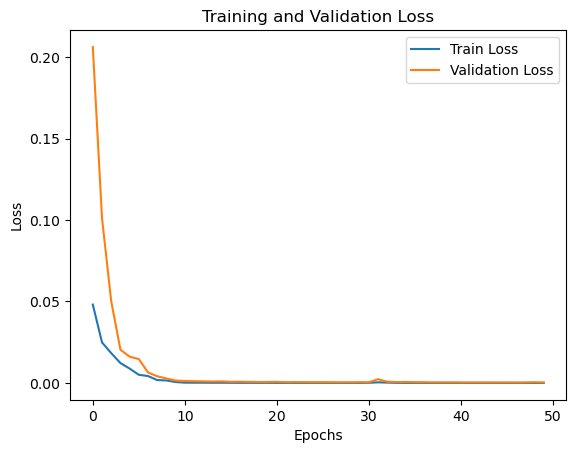

In [101]:
if train_needed:
    # Instantiate the model
    model = CustomRNNModel(
        input_dim=X_train_tensor.shape[-1],
        hidden_dim=num_units,
        output_dim=y_train_tensor.shape[-1],
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        dense_units=dense_units,
        cell_type='lstm'
    )
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model = train_model(model, 'lstm', train_loader, val_loader, epochs=max_epochs, learning_rate=learning_rate, use_early_stop=use_early_stop, early_stop_patience=early_stop_patience, train_needed=train_needed)

else:
    # Load the model
    model.load_state_dict(torch.load(f'models/SP500_lstm_model.pth'))
    print("Model loaded successfully")

Test Loss: 0.0594


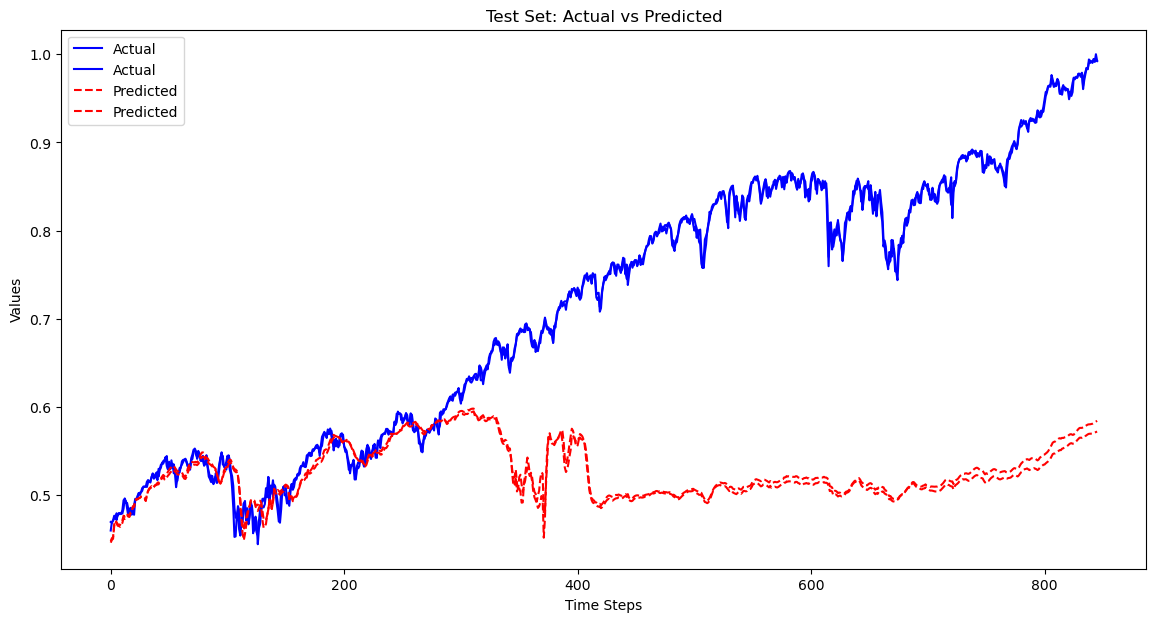

In [103]:
# Evaluate the model on test data & Visualize Results

# Define the function to plot the results
def plot_predictions(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(14, 7))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Fetch the predictions from the test loader
model.eval()
y_preds = []
y_trues = []
test_loss_sum = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Ensure the output shape matches y
        y_preds.append(outputs.numpy())
        y_trues.append(targets.numpy())
        loss = criterion(outputs, targets)
        test_loss_sum += loss.item() * inputs.size(0)

avg_test_loss = test_loss_sum / len(test_loader.dataset)
print(f'Test Loss: {avg_test_loss:.4f}')

# Concatenate the results
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

# Plot the results
plot_predictions(y_trues, y_preds, title="Test Set: Actual vs Predicted")

## Model Definition: GRU Cell

In [ ]:
# Extract hyperparameters
num_units, num_layers, dropout_rate, dense_units, batch_size, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'gru')

In [ ]:
# Build (or load) model
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim))  # Input-to-hidden weight for update gate
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim))  # Hidden-to-hidden weight for update gate
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))  # Bias for update gate
        
        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim))  # Input-to-hidden weight for reset gate
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim))  # Hidden-to-hidden weight for reset gate
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))  # Bias for reset gate
        
        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim))  # Input-to-hidden weight for candidate hidden state
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim))  # Hidden-to-hidden weight for candidate hidden state
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))  # Bias for candidate hidden state
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param, a=0, mode='fan_in', nonlinearity='tanh')
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x, h):
        z_t = torch.sigmoid(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z)
        r_t = torch.sigmoid(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r)
        h_hat_t = torch.tanh(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h)
        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        return h_t

In [ ]:
# Instantiate the model
input_dim = X_train_tensor.shape[-1]
output_dim = y_train_tensor.shape[-1]

model = CustomRNNModel(input_dim=input_dim, hidden_dim=num_units, output_dim=output_dim, num_layers=num_layers, dropout_rate=dropout_rate, cell_type='gru')
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

criterion = nn.MSELoss()
learning_rate = hyperparams['gru']['learning_rate']
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Evaluate the model on test data
model.eval()
test_loss_sum = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
        loss = criterion(outputs, targets)
        test_loss_sum += loss.item() * inputs.size(0)

avg_test_loss = test_loss_sum / len(test_loader.dataset)
print(f'Test Loss: {avg_test_loss:.4f}')

In [ ]:
if train_needed:
    # Train the model
    model = train_model(model, 'gru', train_loader, val_loader, epochs=max_epochs, learning_rate=learning_rate, use_early_stop=use_early_stop, early_stop_patience=early_stop_patience, train_needed=train_needed)
else:
    # Load the model
    model.load_state_dict(torch.load(f'models/SP500_gru_model.pth'))
    print("Model loaded successfully")



In [ ]:
# import numpy as np
# from scipy.special import kl_div

# # Sample data for demonstration purposes
# # In practice, you would use actual activation data from the model
# def get_fp32_activation_data():
#     # Replace this with actual data collection
#     return np.array([0.5, 1.0, 2.0, -1.0, -0.5, 3.0, -3.0, 0.1])

# # **1. Calibration: Collect Data and Compute Scale Factor**

# # Collect activation data (replace with actual FP32 data)
# activation_data_fp32 = get_fp32_activation_data()

# # Step 1: Determine the maximum absolute value
# max_abs_value = np.max(np.abs(activation_data_fp32))

# # Step 2: Compute the scale factor for symmetric quantization
# def compute_scale(max_abs_value):
#     return max_abs_value / 127  # 127 because 8-bit quantization uses values from -128 to 127

# scale = compute_scale(max_abs_value)

# # Step 3: Perform preliminary quantization of FP32 data
# def preliminary_quantize(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8 = preliminary_quantize(activation_data_fp32, scale)

# # Step 4: Compute histograms for FP32 and INT8
# def compute_histograms(fp32_data, int8_data):
#     hist_fp32, _ = np.histogram(fp32_data, bins=2048, range=(-128, 127), density=True)
#     hist_int8, _ = np.histogram(int8_data, bins=2048, range=(-128, 127), density=True)
#     return hist_fp32, hist_int8

# hist_fp32, hist_int8 = compute_histograms(activation_data_fp32, activation_data_int8)

# # Step 5: Compute KL divergence
# def compute_kl_divergence(hist_fp32, hist_int8):
#     # Adding a small constant to avoid log(0)
#     return np.sum(kl_div(hist_fp32 + 1e-8, hist_int8 + 1e-8))

# kl_divergence = compute_kl_divergence(hist_fp32, hist_int8)
# print(f"KL Divergence: {kl_divergence}")

# # **2. Quantization: Convert FP32 to INT8**

# # Final quantization of FP32 data
# def quantize_to_int8(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8_final = quantize_to_int8(activation_data_fp32, scale)

# # **3. INT32 Computations: Perform Layer Operations**

# # Example INT32 computation function
# def int32_computations(weights, activations, bias):
#     # Perform INT32 matrix multiplication and add bias
#     int32_result = np.dot(weights, activations) + bias
#     return int32_result

# # Sample weights and bias for demonstration
# weights = np.array([[1, -1], [2, 3]])
# bias = np.array([1, -1])

# # Perform INT32 computations
# int32_result = int32_computations(weights, activation_data_int8_final, bias)
# print(f"INT32 Computation Result: {int32_result}")

# # **4. Re-Quantization: Convert INT32 to INT8**

# # Re-quantization process
# def requantize(int32_activations, scale, zero_point, bias):
#     # Add bias and then requantize
#     int32_activations_with_bias = int32_activations + bias
#     return np.clip(np.round(int32_activations_with_bias * scale) + zero_point, -128, 127).astype(np.int8)

# # Assuming zero_point = 0 for symmetric quantization
# zero_point = 0

# # Re-quantize INT32 results to INT8
# activation_data_int8_requantized = requantize(int32_result, scale, zero_point, bias)
# print(f"Re-Quantized INT8 Data: {activation_data_int8_requantized}")

# # **5. De-Quantization: Convert INT8 Back to FP32**

# # De-quantization process
# def dequantize_to_fp32(int8_data, scale, zero_point):
#     return (int8_data - zero_point) * scale

# # Convert INT8 results back to FP32
# fp32_reconstructed_data = dequantize_to_fp32(activation_data_int8_requantized, scale, zero_point)
# print(f"De-Quantized FP32 Data: {fp32_reconstructed_data}")